In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.primitives import Sampler, Estimator

from squlearn.feature_map import YZ_CX_FeatureMap
from squlearn.kernel.matrix import ProjectedQuantumKernel
from squlearn.kernel.ml import QKRR
from squlearn.kernel.optimization import KernelOptimizer, NLL, TargetAlignment
from squlearn.util import Executor
from generate_training_data_xsinx import generate_points

# Qiskit version control
import qiskit
print("Qiskit version infos: \n", qiskit.__qiskit_version__)
import qiskit_ibm_runtime
print("runtime version: ", qiskit_ibm_runtime.version.get_version_info() )

C:\Users\jsl\AppData\Roaming\Python\Python310\site-packages\pkg_resources\__init__.py:123: PkgResourcesDeprecationWarning: skit-terra is an invalid version and will not be supported in a future release
  warnings.warn(
C:\Users\jsl\AppData\Roaming\Python\Python310\site-packages\pkg_resources\__init__.py:123: PkgResourcesDeprecationWarning: skit-aer is an invalid version and will not be supported in a future release
  warnings.warn(


Qiskit version infos: 
 {'qiskit-terra': '0.24.0', 'qiskit-aer': '0.12.0', 'qiskit-ignis': '0.7.1', 'qiskit-ibmq-provider': '0.20.2', 'qiskit': '0.43.0', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': '0.4.0', 'qiskit-machine-learning': '0.6.0'}
runtime version:  0.9.4


In [2]:
# load QuantumInstances and Primitives
qinstance_sv = QuantumInstance(backend=Aer.get_backend('statevector_simulator'))
qinstance_qasm = QuantumInstance(backend=Aer.get_backend('qasm_simulator'), shots=5000)
estimator_base = Estimator()
sampler_base = Sampler()

C:\Users\DKR\AppData\Local\Temp\ipykernel_23512\1739260404.py:2: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  qinstance_sv = QuantumInstance(backend=Aer.get_backend('statevector_simulator'))
C:\Users\DKR\AppData\Local\Temp\ipykernel_23512\1739260404.py:3: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  qinstance_qasm = QuantumInstance(backend=Aer.get_backend('qasm_simulator'), shots=5000)


In [3]:
# generate training data (taken from qpr_workflow.ipynb)
training_start = np.pi * 0
training_end = np.pi * 2
noise_variance = 0.2
training_data = generate_points(
    training_start, training_end, section=7, quota=[2, 5], noise=noise_variance
)
x_train, y_train = training_data
x_train_4D = np.repeat(x_train.reshape(-1,1), 4, axis=1)
# Setup testing locations.
# You can change the testing locations here.
x_test = np.linspace(training_start, training_end + 0*np.pi, 50)
x_test_4D = np.repeat(x_test.reshape(-1,1),4, axis=1)
y_test = x_test * np.sin(x_test)

In [4]:
# defining grid search function for approximating inherent PQK hyper parameter
def grid_search(pqk_train_features, pqk_test_features, y_train, y_test, fmap, primitive, rtik, gamma, params=None):
    train_dim = pqk_train_features.shape[0]
    test_dim = pqk_test_features.shape[0]
    l2_loss_list = []
    for i in range(len(gamma)):
        PQK = ProjectedQuantumKernel(
            pqk_hyper_param=gamma[i],
            feature_map=fmap,
            primitive=primitive
        )
        if params is not None:
            PQK.assign_parameters(params)
        kgram = PQK.get_total_gram_matrix(pqk_train_features, pqk_test_features)
        ktrain = kgram[0:train_dim, 0:train_dim]
        ktest = kgram[train_dim:train_dim+test_dim, 0:train_dim]
        alpha = np.linalg.solve(ktrain + rtik * np.eye(ktrain.shape[0]), y_train)
        ypred = ktest @ alpha
        l2_loss_list.append(np.linalg.norm(ypred - y_test) ** 2)
    gamma_opt = gamma[np.argmin(l2_loss_list)]
    min_error = np.min(l2_loss_list)
    return gamma_opt, min_error

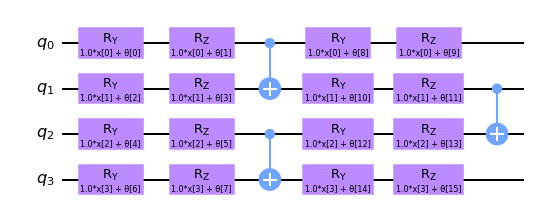

In [5]:
# set up feature map with trainable parameters being randomly initialized
num_qubits = 4
fmap_yz_cx = YZ_CX_FeatureMap(
    num_qubits=4, num_features=num_qubits, num_layers=2, c=1.0
)
np.random.seed(0)
param = np.random.rand(fmap_yz_cx.num_parameters)

fmap_yz_cx.draw()

<b>Estimator primitive, with trainable parameters randomly sampled</b>

In [6]:
# initialize PQK instance
PQK_1 = ProjectedQuantumKernel(
    pqk_hyper_param=2.0, # fix this to a random value for the moment (2.0 is usually a good choice to obtain reasonable results)
    feature_map=fmap_yz_cx,
    primitive=estimator_base
)
PQK_1.assign_parameters(param)

# compute pqk feature vectors, i.e. PQC(x) values
pqk_train_features, pqk_test_features = PQK_1.pqk_features(x_train_4D, x_test_4D)

TypeError: KernelMatrixBase.__init__() takes from 3 to 4 positional arguments but 5 were given

In [ ]:
# grid search for determining optimal hyper parameter
gamma_i = 0.005
gamma_f = 0.1
ngrid = 1000
gamma = np.linspace(gamma_i, gamma_f, ngrid)

rtik = 1.e-3

opt_pqk_hyper_param, min_error = grid_search(
    pqk_train_features, pqk_test_features, y_train, y_test, fmap_yz_cx, estimator_base, rtik, gamma, params=param
)
print("optimial hyperparameter: ", opt_pqk_hyper_param)
print("corresponding min l2-loss: ", min_error)

In [ ]:
PQK_1_opt = ProjectedQuantumKernel(
    pqk_hyper_param=opt_pqk_hyper_param,
    feature_map=fmap_yz_cx,
    primitive=estimator_base
)
PQK_1_opt.assign_parameters(param)
qkrr_instance = QKRR(
    quantum_kernel=PQK_1_opt,
    sigma=1.e-3
)
qkrr_instance.fit(pqk_train_features, y_train)
y_pred_1 = qkrr_instance.predict(pqk_test_features)

In [ ]:
# plot result
plt.plot(x_test.reshape(-1,1), y_pred_1, color='red', label='test prediction')
plt.scatter(x_test.reshape(-1,1), y_test, marker='.',label='test points', color='red', alpha=0.7)
plt.scatter(x_train, y_train, marker='x', label='training points')
plt.plot(x_test,y_test, label=r"$f(x) = x sin(x)$", linestyle="dotted")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")

<b>Optimize trainable parameters via negative log likelihood</b>

In [ ]:
PQK_3 = ProjectedQuantumKernel(
    pqk_hyper_param=opt_pqk_hyper_param,
    feature_map=fmap_yz_cx,
    primitive=estimator_base
)

In [ ]:
from squlearn.kernel.optimization import frederics_adam as adam

adam = adam.ADAM(maxiter=50, lr=0.1)
nll_loss_3 = NLL(quantum_kernel=PQK_3, sigma=1e-3)
pqk_optimizer_3 = KernelOptimizer(loss=nll_loss_3, optimizer=adam, initial_parameters=param)

pqk_optimizer_results_3 = pqk_optimizer_3.run_optimization(x=x_train.reshape(-1,1), y=y_train)

In [ ]:
param_opt_3 = pqk_optimizer_results_3.x
PQK_3.assign_parameters(param_opt_3)
# compute pqk feature vectors with optimized trainable parameters, i.e. PQC(x) values
pqk_train_features_opt_3, pqk_test_features_opt_3 = PQK_3.pqk_features(x_train_4D, x_test_4D)

In [ ]:
# grid search for determining optimal hyper parameter based on using optimal trainable paramaters
gamma_i = 0.001
gamma_f = 0.1
ngrid = 1000
gamma = np.linspace(gamma_i, gamma_f, ngrid)

rtik = 1e-3

opt_pqk_hyper_param_3, min_error_3 = grid_search(
    pqk_train_features_opt_3, pqk_test_features_opt_3, y_train, y_test, fmap_yz_cx, estimator_base, rtik, gamma, params=param_opt_3
)
print("optimial hyperparameter: ", opt_pqk_hyper_param_3)
print("corresponding min l2-loss: ", min_error_3)

In [ ]:
PQK_3_opt = ProjectedQuantumKernel(
    pqk_hyper_param=opt_pqk_hyper_param_3,
    feature_map=fmap_yz_cx,
    primitive=estimator_base
)
PQK_3_opt.assign_parameters(param_opt_3)
qkrr_instance = QKRR(
    quantum_kernel=PQK_3_opt,
    sigma=1.e-3
)
qkrr_instance.fit(pqk_train_features_opt_3, y_train)
y_pred_3 = qkrr_instance.predict(pqk_test_features_opt_3)

In [ ]:
# plot result
plt.plot(x_test.reshape(-1,1), y_pred_3, color='red', label='test prediction')
plt.scatter(x_test.reshape(-1,1), y_test, marker='.',label='test points', color='red', alpha=0.7)
plt.scatter(x_train, y_train, marker='x', label='training points')
plt.plot(x_test,y_test, label=r"$f(x) = x sin(x)$", linestyle="dotted")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")

<b>Optimize trainable parameters via target alignment</b>

In [ ]:
ta_loss = TargetAlignment(quantum_kernel=PQK_3, sigma=1e-3)
pqk_optimizer_ta = KernelOptimizer(loss=ta_loss, optimizer=adam, initial_parameters=param)

pqk_optimizer_results_ta = pqk_optimizer_ta.run_optimization(x=x_train.reshape(-1,1), y=y_train)

In [ ]:
param_opt_ta = pqk_optimizer_results_ta.x
PQK_3.assign_parameters(param_opt_ta)
# compute pqk feature vectors with optimized trainable parameters, i.e. PQC(x) values
pqk_train_features_opt_ta, pqk_test_features_opt_ta = PQK_3.pqk_features(x_train_4D, x_test_4D)

In [ ]:
PQK_3_ta_opt = ProjectedQuantumKernel(
    pqk_hyper_param=opt_pqk_hyper_param,
    feature_map=fmap_yz_cx,
    primitive=estimator_base
)
PQK_3_ta_opt.assign_parameters(param_opt_ta)
qkrr_instance = QKRR(
    quantum_kernel=PQK_3_ta_opt,
    sigma=1.e-3
)
qkrr_instance.fit(pqk_train_features_opt_ta, y_train)
y_pred_ta = qkrr_instance.predict(pqk_test_features_opt_ta)

In [ ]:
# plot result
plt.plot(x_test.reshape(-1,1), y_pred_ta, color='red', label='test prediction')
plt.scatter(x_test.reshape(-1,1), y_test, marker='.',label='test points', color='red', alpha=0.7)
plt.scatter(x_train, y_train, marker='x', label='training points')
plt.plot(x_test,y_test, label=r"$f(x) = x sin(x)$", linestyle="dotted")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")